In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import  tarfile
import os
import re
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/avlasova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [40]:
fragments_path = "/data/fragments.tar"
abstracts_path = "/data/abstracts.tar"

In [54]:
tar_fragments = tarfile.open(os.getenv("HOME") + fragments_path)
tar_members_fragments = tar_fragments.getmembers()

tar_abstracts = tarfile.open(os.getenv("HOME") + abstracts_path)
tar_members_abstracts = tar_abstracts.getmembers()

In [42]:
assert len(tar_members_abstracts) == len(tar_members_fragments)

In [43]:
def divide_article_id(article):
    id_splitted = article.split('/')
    article_id, second_id = id_splitted[1].split('.')[0], id_splitted[2]
    return pd.Series([article_id, second_id])

In [44]:
def standartize(text):
    text = text.replace('--', '-')
    text = text.replace(';', ".")
    text = text.replace('...', ".")
    text = text.replace('..', ".")
    text = text.replace("'''", "'")
    text = text.replace("''", "'")
    text = text.replace("```", "`")
    text = text.replace("``", "`")
    text = text.strip()
    
    text = re.sub(r'\([^\)]*\)', '', text)

    text = re.sub(r'\[xref\]', '', text)
    text = re.sub(r'\[[^]]*\]', '', text)
    text = text.replace(" ,", ",")
    text = text.replace(" .", ".")
#     text = re.sub(r'[\(|\[]\[xref\][\)|]]|\[xref\]', '', text)
#     text = re.sub(r'\([https|http](.*?)\)', '', text)
    return text

In [51]:
def write_to_file(article):
    article_id, full_text, abstract = article
    article_sentences = nltk.tokenize.sent_tokenize(full_text)
    abstract_sentences = nltk.tokenize.sent_tokenize(abstract)
    
    full_text = '\n\n'.join(article_sentences)
    
    sep = '@highlight\n\n'
    summary = sep + ('\n\n' + sep).join(abstract_sentences)
    
    res_article = '\n\n'.join([full_text, summary])
        
    f = open(os.getenv("HOME") + '/PreSumm/raw_data/{}.paper'.format(article_id),'w+')
    f.write(res_article)
    f.close()

In [53]:
n_files_to_add = 6
for fragments_member, abstracts_member in list(zip(tar_members_fragments, tar_members_abstracts))[:n_files_to_add]:
    fragments_file = tar_fragments.extractfile(fragments_member)
    fragments_df = pd.read_csv(fragments_file, sep='\t', header=None, 
                               names=['id', 'fragment_text']).dropna()

    abstracts_file = tar_abstracts.extractfile(abstracts_member)
    abstracts_df = pd.read_csv(abstracts_file, sep='\t', header=None, 
                               names=['id', 'abstract_text']).dropna()

    abstracts_df[['article_id', 'abstract_id']] = abstracts_df['id'].apply(lambda row: divide_article_id(row))
    fragments_df[['article_id', 'fragment_id']] = fragments_df['id'].apply(lambda row: divide_article_id(row))

    fragments_df.drop(columns=['id'], inplace=True)
    abstracts_df.drop(columns=['id'], inplace=True)

    texts_df = fragments_df.groupby('article_id')['fragment_text']\
                .apply(lambda x: '\n'.join(x)).reset_index()\
                .rename(columns={'fragment_text':'article_text'})

    papers_df = pd.merge(texts_df, abstracts_df, on='article_id')
    papers_df = papers_df[papers_df['abstract_id'].astype(int) == 1]
    
    print("Standartizing texts...")

    papers_df['article_text_standartized'] = papers_df['article_text'].apply(lambda text: standartize(text))
    papers_df['abstract_text_standartized'] = papers_df['abstract_text'].apply(lambda text: standartize(text))

    papers_df[['article_id', 'article_text_standartized', 'abstract_text_standartized']].apply(lambda article: write_to_file(article), axis=1)

Standartizing texts...
Standartizing texts...


### Summary on Pubtrends dataset

##### Number of sentences

In [464]:
papers_df['abstract_n_sent_st'] = papers_df['abstract_text_standartized'].apply(lambda text: len(nltk.tokenize.sent_tokenize(text)))

In [465]:
papers_df = papers_df[papers_df['abstract_n_sent_st'] < 1000]

median sentence amount in abstract:  9.0


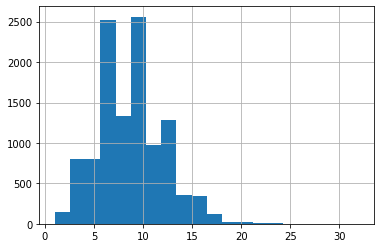

In [467]:
papers_df['abstract_n_sent_st'].hist(bins=20)
print("median sentence amount in abstract: ", papers_df['abstract_n_sent_st'].median())

In [468]:
papers_df['article_n_sent_st'] = papers_df['article_text_standartized'].apply(lambda text: len(nltk.tokenize.sent_tokenize(text)))

In [470]:
papers_df

,article_id,article_text,abstract_text,abstract_id,article_text_standartized,abstract_text_standartized,abstract_n_sent_st,article_n_sent_st
0,PMC1510899,This study examined the association between pl...,This study examined the association between pl...,1,This study examined the association between pl...,This study examined the association between pl...,9,9
1,PMC1693572,To determine whether observed changes in HIV p...,To determine whether observed changes in HIV p...,1,To determine whether observed changes in HIV p...,To determine whether observed changes in HIV p...,8,8
2,PMC1794711,The negative effect of poverty on child health...,The negative effect of poverty on child health...,1,The negative effect of poverty on child health...,The negative effect of poverty on child health...,13,13
3,PMC1798306,The recently accomplished complete genomic seq...,The recently accomplished complete genomic seq...,1,The recently accomplished complete genomic seq...,The recently accomplished complete genomic seq...,8,8
4,PMC1800823,The genus Rickettsia consists of intracellular...,The genus Rickettsia consists of intracellular...,1,The genus Rickettsia consists of intracellular...,The genus Rickettsia consists of intracellular...,7,7
...,...,...,...,...,...,...,...,...
11297,PMC6445367,"The development, maintenance of healthy bone a...","The development, maintenance of healthy bone a...",1,"The development, maintenance of healthy bone a...","The development, maintenance of healthy bone a...",5,5
11298,PMC6448565,Despite its revolutionary success in hematolog...,Despite its revolutionary success in hematolog...,1,Despite its revolutionary success in hematolog...,Despite its revolutionary success in hematolog...,6,6
11299,PMC6449497,Frontal electroencephalographic (EEG) alpha as...,Frontal electroencephalographic (EEG) alpha as...,1,Frontal electroencephalographic alpha asymmet...,Frontal electroencephalographic alpha asymmet...,7,7
11300,PMC6450511,This article provides an overview of recent as...,This article provides an overview of recent as...,1,This article provides an overview of recent as...,This article provides an overview of recent as...,8,8


median sentence amount in article: 9.0


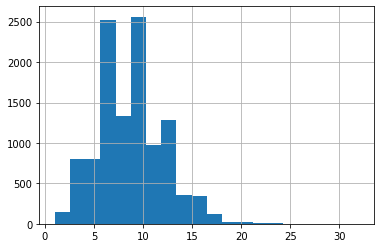

In [469]:
papers_df = papers_df[papers_df['article_n_sent_st'] < 2000]
papers_df['article_n_sent_st'].hist(bins=20)
print("median sentence amount in article:", papers_df['article_n_sent_st'].median())

##### Number of words

In [67]:
from nltk.tokenize import word_tokenize

In [405]:
papers_df['abstract_n_word_st'] = papers_df['abstract_text_standartized'].apply(lambda text: len(word_tokenize(text)))

In [406]:
papers_df['abstract_n_word_st'] = papers_df['abstract_text_standartized'].apply(lambda text: len(word_tokenize(text)))

median word count in abstract: 207.0


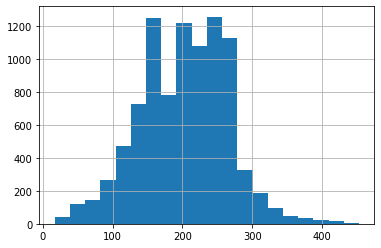

In [408]:
papers_df['abstract_n_word_st'].hist(bins=20)
print("median word count in abstract:", papers_df['abstract_n_word_st'].median())

In [409]:
papers_df['article_n_word_st'] = papers_df['article_text_standartized'].apply(lambda text: len(word_tokenize(text)))

median word count in article: 3854.0


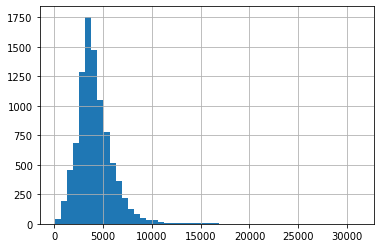

In [410]:
papers_df['article_n_word_st'].hist(bins=50)
print("median word count in article:", papers_df['article_n_word_st'].median())

In [411]:
print("average number of words in article sentences: ", 
      papers_df['article_n_word_st'].sum() / papers_df['article_n_sent_st'].sum())
print("average number of words in abstract sentences: ", 
      papers_df['abstract_n_word_st'].sum() / papers_df['abstract_n_sent_st'].sum())

average number of words in article sentences:  25.018949942400496
average number of words in abstract sentences:  23.447133134088453


___

### Summary on CNN dataset

In [197]:
cnn_path = "/BertSum/raw_stories/cnn_stories.tgz"
tar = tarfile.open(os.getenv("HOME") + cnn_path)
tar_members = tar.getmembers()

In [232]:
summary_n_sent = []
stories_n_sent = []
summary_n_words = []
stories_n_words = []

for member in tar_members[1:]:
    cnn_file = tar.extractfile(member)
    text = cnn_file.read().decode("utf-8")
    sep_index = text.find("@highlight")
    
    story, summary = text[:sep_index], text[sep_index:]
    
    story = nltk.tokenize.sent_tokenize(story)
    story = list(map(lambda sent: sent.replace("\n", ""), story))
    
    summary = summary.split("\n\n@highlight\n\n")
    summary[0] = summary[0].replace("@highlight\n\n", "")
    
    # add statistics
    stories_n_sent.append(len(story))
    summary_n_sent.append(len(summary))
    
    stories_n_words.append(sum(map(lambda sent: len(word_tokenize(sent)), story)))
    summary_n_words.append(sum(map(lambda sent: len(word_tokenize(sent)), summary)))

#     for sent in story:
#         stories_n_words.append(len(word_tokenize(sent)))
#     for sent in summary:
#         summary_n_words.append(len(word_tokenize(sent)))

Median sentence count in story : 29.0


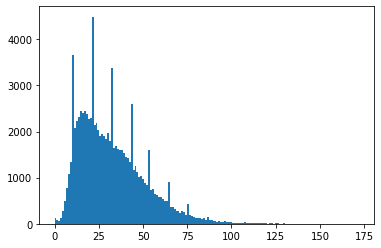

In [238]:
plt.hist(stories_n_sent, bins='auto')
print("Median sentence count in story :", np.median(stories_n_sent))

Median sentence count in story summary : 4.0


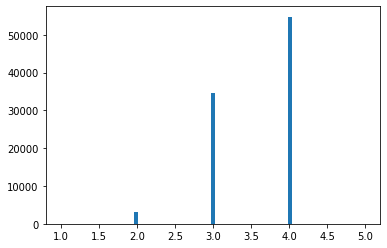

In [237]:
plt.hist(summary_n_sent, bins='auto')
print("Median sentence count in story summary :", np.median(summary_n_sent))

Median word count in story : 699.0


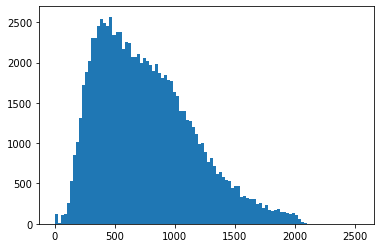

In [235]:
plt.hist(stories_n_words, bins=100)
print("Median word count in story :", np.median(stories_n_words))

Median word count in story summary : 46.0


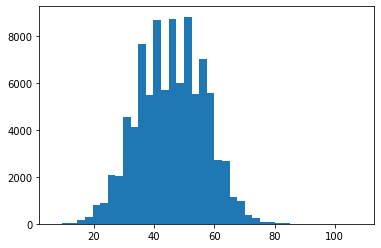

In [236]:
plt.hist(summary_n_words, bins=40)
print("Median word count in story summary :", np.median(summary_n_words))

____